# Test Task for DS

The task is organized as a competition on the Kaggle platform and is available at the following [link](https://www.kaggle.com/competitions/test-task-for-ds-time-series-forecasting-2025-01/overview).

Possible improvemets:
* handle outliers explicitly by capping/extending feature values (e.g., winsorization);
* make logarithmization before data aggregation to the weekly basis to simplify the code;
* add artificial features, like store_id * cat_id or month * item_id;
* add features like the rolling standard deviation or maximum sales in the past few weeks.

## Technical task

The task is to predict sales based on a dataset created from real-world data from Walmart. The dataset includes information on product sales in four stores in one US state from January 1, 2014 to May 15, 2016, including a calendar of special events (holidays) that could affect sales in certain categories. The time series may vary in length because the products were introduced to stores gradually. In total, you need to work with 405 time series, each of which reflects daily sales of a specific product in a specific store.

This dataset contains the following columns:

* 'date' — date of sale,
* 'index' — unique (synthetic) time series identifier,
* 'store_id' — store identifier,
* 'cat_id' — product category identifier,
* 'dept_id' — product subcategory identifier,
* 'item_id' — product identifier,
* 'event_name_1' — calendar event name,
* 'event_type_1' — calendar event type,
* 'event_name_2' — additional calendar event,
* 'event_type_2' — additional calendar event type,
* 'qnt' — quantity of product units sold (target).

The task is to predict the total sales volume (number of units) for each time series for the week from May 16 to 22, 2016. The forecast results should be saved in a csv file in the following format:

```
index,y
0_FOODS_1_0,5
0_FOODS_1_1,5
0_FOODS_1_10,5
0_FOODS_1_11,5
0_FOODS_1_13,5
...
3_HOUSEHOLD_2_169,5
3_HOUSEHOLD_2_171,5
3_HOUSEHOLD_2_177,5
3_HOUSEHOLD_2_179,5
3_HOUSEHOLD_2_180,5
```

In the file, for each identifier (index), you need to specify the predicted value of the variable y for the week ahead.

### 1. EDA

#### 1.1. Downloading the required packages and dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import optuna
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
file_path = "/kaggle/input/test-task-for-ds-time-series-forecasting-2025-01/ts_hist.csv"

data = pd.read_csv(file_path)

print(data.shape)
data.head()

(239511, 11)


,date,index,store_id,cat_id,dept_id,item_id,event_name_1,event_type_1,event_name_2,event_type_2,qnt
0,2014-01-01,0_FOODS_1_0,0,FOODS,FOODS_1,0,NewYear,National,NaN,NaN,23
1,2014-01-02,0_FOODS_1_0,0,FOODS,FOODS_1,0,NaN,NaN,NaN,NaN,28
2,2014-01-03,0_FOODS_1_0,0,FOODS,FOODS_1,0,NaN,NaN,NaN,NaN,43
3,2014-01-04,0_FOODS_1_0,0,FOODS,FOODS_1,0,NaN,NaN,NaN,NaN,33
4,2014-01-05,0_FOODS_1_0,0,FOODS,FOODS_1,0,NaN,NaN,NaN,NaN,32


#### 1.2. Preliminary analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239511 entries, 0 to 239510
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   date          239511 non-null  object
 1   index         239511 non-null  object
 2   store_id      239511 non-null  int64 
 3   cat_id        239511 non-null  object
 4   dept_id       239511 non-null  object
 5   item_id       239511 non-null  int64 
 6   event_name_1  19586 non-null   object
 7   event_type_1  19586 non-null   object
 8   event_name_2  510 non-null     object
 9   event_type_2  510 non-null     object
 10  qnt           239511 non-null  int64 
dtypes: int64(3), object(8)
memory usage: 20.1+ MB


In [4]:
data.nunique()

date            866
index           405
store_id          4
cat_id            3
dept_id           7
item_id         181
event_name_1     30
event_type_1      4
event_name_2      2
event_type_2      2
qnt             234
dtype: int64

From the previous analysis, it is clear that there are no data gaps in the indexes, store IDs, and products. Let's check if there are any gaps in the dates. To do this, first convert the dates from string to datetime format.

In [5]:
data['date'] = pd.to_datetime(data['date'])

#### 1.3. Check for missed dates.

In [6]:
full_date_range = pd.date_range(start=data['date'].min(), end=data['date'].max())

missing_dates = full_date_range.difference(data['date'])

missing_dates_list = missing_dates.tolist()
missing_dates_list

[]

There are no gaps in the data set.

#### 1.4. Check the holidays that coincide.

In [7]:
events_not_nan = data[data['event_name_1'].notna() & data['event_name_2'].notna()]
events_not_nan.head()

,date,index,store_id,cat_id,dept_id,item_id,event_name_1,event_type_1,event_name_2,event_type_2,qnt
98,2014-04-20,0_FOODS_1_0,0,FOODS,FOODS_1,0,Easter,Cultural,OrthodoxEaster,Religious,26
154,2014-06-15,0_FOODS_1_0,0,FOODS,FOODS_1,0,NBAFinalsEnd,Sporting,Father's day,Cultural,25
814,2014-04-20,2_FOODS_1_0,2,FOODS,FOODS_1,0,Easter,Cultural,OrthodoxEaster,Religious,15
868,2014-06-15,2_FOODS_1_0,2,FOODS,FOODS_1,0,NBAFinalsEnd,Sporting,Father's day,Cultural,30
1467,2014-04-20,0_FOODS_1_1,0,FOODS,FOODS_1,1,Easter,Cultural,OrthodoxEaster,Religious,1


In [8]:
len(events_not_nan)

510

In [9]:
events_not_nan.nunique()

date              2
index           324
store_id          4
cat_id            3
dept_id           7
item_id         155
event_name_1      2
event_type_1      2
event_name_2      2
event_type_2      2
qnt              55
dtype: int64

In this dataset, holidays overlapped only twice, in 2014, Easter coincided with Orthodox Easter, and the NBA Finals End coincided with Father's Day.

### 2. Data Preparation

#### 2.1. Data aggregation to the weekly level

Since the task requires predicting weekly sales, it is better to aggregate the data set to the weekly level.

In [10]:
data['week'] = data['date'].dt.to_period('W-SUN')

weekly_data = data.groupby(['index', 'week'])['qnt'].sum().reset_index()

weekly_data.rename(columns={'qnt': 'weekly_sales'}, inplace=True)

print(weekly_data.shape)
weekly_data.head()

(44621, 3)


,index,week,weekly_sales
0,0_FOODS_1_0,2013-12-30/2014-01-05,159
1,0_FOODS_1_0,2014-01-06/2014-01-12,190
2,0_FOODS_1_0,2014-01-13/2014-01-19,87
3,0_FOODS_1_0,2014-01-20/2014-01-26,77
4,0_FOODS_1_0,2014-01-27/2014-02-02,43


The data set ends on Sunday, May 15, 2016, but begins on Wednesday, January 1, 2014, so the initial week is incomplete. This incomplete week can be removed or adjusted to account for the two missing days. Let's multiply all weekly sales that fall on the week of 2013-12-30/2014-01-05 by 7/5.

In [11]:
week_to_adjust = '2013-12-30/2014-01-05'

weekly_data['weekly_sales'] = weekly_data['weekly_sales'].astype(float)
weekly_data.loc[weekly_data['week'] == week_to_adjust, 'weekly_sales'] *= 1.4
weekly_data['weekly_sales'] = weekly_data['weekly_sales'].round().astype(int)

print(weekly_data.shape)
weekly_data.head()

(44621, 3)


,index,week,weekly_sales
0,0_FOODS_1_0,2013-12-30/2014-01-05,223
1,0_FOODS_1_0,2014-01-06/2014-01-12,190
2,0_FOODS_1_0,2014-01-13/2014-01-19,87
3,0_FOODS_1_0,2014-01-20/2014-01-26,77
4,0_FOODS_1_0,2014-01-27/2014-02-02,43


#### 2.2. Adding placeholder for the week May 16-22, 2016

In [12]:
predict_week = pd.Period('2016-05-16/2016-05-22', freq='W-SUN')

last_week_data = weekly_data[weekly_data['week'] == weekly_data['week'].max()]
placeholder_data = last_week_data.copy()
placeholder_data['week'] = predict_week
placeholder_data['weekly_sales'] = 0

print(placeholder_data.shape)
placeholder_data.head()

(389, 3)


,index,week,weekly_sales
110,0_FOODS_1_0,2016-05-16/2016-05-22,0
234,0_FOODS_1_1,2016-05-16/2016-05-22,0
356,0_FOODS_1_10,2016-05-16/2016-05-22,0
480,0_FOODS_1_11,2016-05-16/2016-05-22,0
604,0_FOODS_1_13,2016-05-16/2016-05-22,0


In [13]:
last_week_data.nunique()

index           389
week              1
weekly_sales    126
dtype: int64

In [14]:
weekly_data.nunique()

index           405
week            124
weekly_sales    684
dtype: int64

It is interesting to note that only 389 items out of 405 were sold in the last week.

In [15]:
weekly_data = pd.concat([weekly_data, placeholder_data], ignore_index=True).sort_values(by=['index', 'week'])

print(weekly_data.shape)
weekly_data.head()

(45010, 3)


,index,week,weekly_sales
0,0_FOODS_1_0,2013-12-30/2014-01-05,223
1,0_FOODS_1_0,2014-01-06/2014-01-12,190
2,0_FOODS_1_0,2014-01-13/2014-01-19,87
3,0_FOODS_1_0,2014-01-20/2014-01-26,77
4,0_FOODS_1_0,2014-01-27/2014-02-02,43


#### 2.3. Check for the missing labels during the last week of the data set

In [16]:
all_labels = set(weekly_data['index'].unique())

last_week = pd.Period('2016-05-09/2016-05-15', freq='W-SUN')
labels_in_last_week = set(weekly_data[weekly_data['week'] == last_week]['index'].unique())

missing_labels = all_labels - labels_in_last_week

last_occurrences = weekly_data[weekly_data['index'].isin(missing_labels)].groupby('index')['week'].max()
first_occurrences = weekly_data[weekly_data['index'].isin(missing_labels)].groupby('index')['week'].min()

missing_labels_df = pd.DataFrame({
    'index': last_occurrences.index,
    'last_occurrence': last_occurrences.values,
    'first_occurrence': first_occurrences.values
}).sort_values(by='last_occurrence')

print(missing_labels_df.shape)
missing_labels_df.head()

(16, 3)


,index,last_occurrence,first_occurrence
12,3_HOBBIES_1_93,2015-11-30/2015-12-06,2013-12-30/2014-01-05
0,0_HOBBIES_1_93,2016-01-04/2016-01-10,2013-12-30/2014-01-05
7,2_HOBBIES_1_93,2016-01-25/2016-01-31,2013-12-30/2014-01-05
2,0_HOBBIES_2_115,2016-01-25/2016-01-31,2013-12-30/2014-01-05
11,2_HOBBIES_2_126,2016-03-07/2016-03-13,2014-01-20/2014-01-26


During the last week of the dataset, 5 product names are missing. As can be seen from the dates of their first and last appearance, these must be seasonal products that are not sold at the end of May, so we decide to replace their values with zeros in the summary table.

### 3. Feature Engineering

To predict sales, it is planned to use a LightGBM model, for which all inputs must be in numerical format.

#### 3.1. Adding time-based features to the new dataframe.

In [17]:
weekly_data['week_of_year'] = weekly_data['week'].dt.week
weekly_data['quarter'] = weekly_data['week'].dt.quarter
weekly_data['year'] = weekly_data['week'].dt.year

season_map = {12: 'Winter', 1: 'Winter', 2: 'Winter',
              3: 'Spring', 4: 'Spring', 5: 'Spring',
              6: 'Summer', 7: 'Summer', 8: 'Summer',
              9: 'Fall', 10: 'Fall', 11: 'Fall'}
weekly_data['month'] = weekly_data['week'].dt.month
weekly_data['season'] = weekly_data['month'].map(season_map)

weekly_data['season_encoded'] = weekly_data['season'].astype('category').cat.codes

weekly_data = weekly_data.drop(columns=['season'], errors='ignore')

print(weekly_data.shape)
weekly_data.head()

(45010, 8)


,index,week,weekly_sales,week_of_year,quarter,year,month,season_encoded
0,0_FOODS_1_0,2013-12-30/2014-01-05,223,1,1,2014,1,3
1,0_FOODS_1_0,2014-01-06/2014-01-12,190,2,1,2014,1,3
2,0_FOODS_1_0,2014-01-13/2014-01-19,87,3,1,2014,1,3
3,0_FOODS_1_0,2014-01-20/2014-01-26,77,4,1,2014,1,3
4,0_FOODS_1_0,2014-01-27/2014-02-02,43,5,1,2014,2,3


#### 3.2. One-hot encoding of the event features

Regarding non-holiday days during the week, its column will not contain 1, but a number of non-holiday days during the week.

In [18]:
event_features = ['event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']

for feature in event_features:
    data[feature] = data[feature].fillna('None')

encoded_events = pd.get_dummies(data[event_features], prefix=event_features)

event_data_weekly = pd.concat([data[['index', 'week']], encoded_events], axis=1)
event_data_weekly = event_data_weekly.groupby(['index', 'week']).sum().reset_index()

weekly_data = weekly_data.merge(event_data_weekly, on=['index', 'week'], how='left')

print(weekly_data.shape)
weekly_data.head()

(45010, 50)


,index,week,weekly_sales,week_of_year,quarter,year,month,season_encoded,event_name_1_Chanukah End,event_name_1_Christmas,...,event_type_1_National,event_type_1_None,event_type_1_Religious,event_type_1_Sporting,event_name_2_Father's day,event_name_2_None,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_None,event_type_2_Religious
0,0_FOODS_1_0,2013-12-30/2014-01-05,223,1,1,2014,1,3,0.0,0.0,...,1.0,4.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0
1,0_FOODS_1_0,2014-01-06/2014-01-12,190,2,1,2014,1,3,0.0,0.0,...,0.0,6.0,1.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0
2,0_FOODS_1_0,2014-01-13/2014-01-19,87,3,1,2014,1,3,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0
3,0_FOODS_1_0,2014-01-20/2014-01-26,77,4,1,2014,1,3,0.0,0.0,...,1.0,6.0,0.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0
4,0_FOODS_1_0,2014-01-27/2014-02-02,43,5,1,2014,2,3,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,0.0


There were no holidays or major sporting events in the week to be forecasted, it's required to include this data in the extended dataset.

In [19]:
columns_for_non_holidays = ["event_type_1_None", "event_type_2_None", "event_name_1_None", "event_name_2_None"]

for item in columns_for_non_holidays:
    weekly_data[item] = weekly_data[item].fillna(7)

weekly_data = weekly_data.fillna(0)

#### 3.3. Adding lagged sales from the previous 3 weeks.

The first three weeks of 2014 have no predecessors, we will add them by simply copying the data from the first week of 2014, since this week is also a holiday, like the last weeks of 2013.

In [20]:
first_week_2014 = '2013-12-30/2014-01-05'
added_weeks = ['2013-11-18/2013-11-24', 
               '2013-11-25/2013-12-01', 
               '2013-12-02/2013-12-08', 
               '2013-12-09/2013-12-15', 
               '2013-12-16/2013-12-22', 
               '2013-12-23/2013-12-29']

first_week_data = weekly_data[weekly_data['week'] == first_week_2014]

additional_rows = pd.concat([
    first_week_data.assign(week=pd.Period(week, freq='W-SUN')) for week in added_weeks
], ignore_index=True)

extended_weekly_data = pd.concat([weekly_data, additional_rows], ignore_index=True).sort_values(by=['index', 'week'])

for lag in [1, 2, 3, 4, 5, 6]:
    extended_weekly_data[f'lag_{lag}_week_sales'] = (
        extended_weekly_data.groupby('index')['weekly_sales'].shift(lag)
    )

print(extended_weekly_data.shape)
extended_weekly_data.head()

(46822, 56)


,index,week,weekly_sales,week_of_year,quarter,year,month,season_encoded,event_name_1_Chanukah End,event_name_1_Christmas,...,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_None,event_type_2_Religious,lag_1_week_sales,lag_2_week_sales,lag_3_week_sales,lag_4_week_sales,lag_5_week_sales,lag_6_week_sales
45010,0_FOODS_1_0,2013-11-18/2013-11-24,223,1,1,2014,1,3,0.0,0.0,...,0.0,0.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
45312,0_FOODS_1_0,2013-11-25/2013-12-01,223,1,1,2014,1,3,0.0,0.0,...,0.0,0.0,5.0,0.0,223.0,NaN,NaN,NaN,NaN,NaN
45614,0_FOODS_1_0,2013-12-02/2013-12-08,223,1,1,2014,1,3,0.0,0.0,...,0.0,0.0,5.0,0.0,223.0,223.0,NaN,NaN,NaN,NaN
45916,0_FOODS_1_0,2013-12-09/2013-12-15,223,1,1,2014,1,3,0.0,0.0,...,0.0,0.0,5.0,0.0,223.0,223.0,223.0,NaN,NaN,NaN
46218,0_FOODS_1_0,2013-12-16/2013-12-22,223,1,1,2014,1,3,0.0,0.0,...,0.0,0.0,5.0,0.0,223.0,223.0,223.0,223.0,NaN,NaN


#### 3.4. Adding rolling features (mean and sum of sales) over last three weeks

Also removing the artificial last three weeks of 2013.

In [21]:
rolling_window = 3

extended_weekly_data['rolling_mean_3_week'] = (
    extended_weekly_data.groupby('index')['weekly_sales']
    .transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean())
)
extended_weekly_data['rolling_sum_3_week'] = (
    extended_weekly_data.groupby('index')['weekly_sales']
    .transform(lambda x: x.rolling(window=rolling_window, min_periods=1).sum())
)

rolling_window = 2

extended_weekly_data['rolling_mean_2_week'] = (
    extended_weekly_data.groupby('index')['weekly_sales']
    .transform(lambda x: x.rolling(window=rolling_window, min_periods=1).mean())
)
extended_weekly_data['rolling_sum_2_week'] = (
    extended_weekly_data.groupby('index')['weekly_sales']
    .transform(lambda x: x.rolling(window=rolling_window, min_periods=1).sum())
)

weekly_data = extended_weekly_data[~extended_weekly_data['week'].isin(pd.PeriodIndex(added_weeks, freq='W-SUN'))]

print(weekly_data.shape)
weekly_data.head()

(45010, 60)


,index,week,weekly_sales,week_of_year,quarter,year,month,season_encoded,event_name_1_Chanukah End,event_name_1_Christmas,...,lag_1_week_sales,lag_2_week_sales,lag_3_week_sales,lag_4_week_sales,lag_5_week_sales,lag_6_week_sales,rolling_mean_3_week,rolling_sum_3_week,rolling_mean_2_week,rolling_sum_2_week
0,0_FOODS_1_0,2013-12-30/2014-01-05,223,1,1,2014,1,3,0.0,0.0,...,223.0,223.0,223.0,223.0,223.0,223.0,223.000000,669.0,223.0,446.0
1,0_FOODS_1_0,2014-01-06/2014-01-12,190,2,1,2014,1,3,0.0,0.0,...,223.0,223.0,223.0,223.0,223.0,223.0,212.000000,636.0,206.5,413.0
2,0_FOODS_1_0,2014-01-13/2014-01-19,87,3,1,2014,1,3,0.0,0.0,...,190.0,223.0,223.0,223.0,223.0,223.0,166.666667,500.0,138.5,277.0
3,0_FOODS_1_0,2014-01-20/2014-01-26,77,4,1,2014,1,3,0.0,0.0,...,87.0,190.0,223.0,223.0,223.0,223.0,118.000000,354.0,82.0,164.0
4,0_FOODS_1_0,2014-01-27/2014-02-02,43,5,1,2014,2,3,0.0,0.0,...,77.0,87.0,190.0,223.0,223.0,223.0,69.000000,207.0,60.0,120.0


#### 3.5. Encoding non-sales categorical features

Let's get these features directly from the index and encode them.

In [22]:
weekly_data.loc[:, 'store_id'] = weekly_data['index'].str.split('_').str[0].astype(int)
weekly_data.loc[:, 'cat_id'] = weekly_data['index'].str.split('_').str[1]
weekly_data.loc[:, 'dept_id'] = weekly_data['index'].str.split('_').str[1:3].str.join('_')
weekly_data.loc[:, 'item_id'] = weekly_data['index'].str.split('_').str[3].astype(int)

weekly_data.head()

<ipython-input-22-3c3bb56e5d36>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_data.loc[:, 'store_id'] = weekly_data['index'].str.split('_').str[0].astype(int)
<ipython-input-22-3c3bb56e5d36>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_data.loc[:, 'cat_id'] = weekly_data['index'].str.split('_').str[1]
<ipython-input-22-3c3bb56e5d36>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,index,week,weekly_sales,week_of_year,quarter,year,month,season_encoded,event_name_1_Chanukah End,event_name_1_Christmas,...,lag_5_week_sales,lag_6_week_sales,rolling_mean_3_week,rolling_sum_3_week,rolling_mean_2_week,rolling_sum_2_week,store_id,cat_id,dept_id,item_id
0,0_FOODS_1_0,2013-12-30/2014-01-05,223,1,1,2014,1,3,0.0,0.0,...,223.0,223.0,223.000000,669.0,223.0,446.0,0,FOODS,FOODS_1,0
1,0_FOODS_1_0,2014-01-06/2014-01-12,190,2,1,2014,1,3,0.0,0.0,...,223.0,223.0,212.000000,636.0,206.5,413.0,0,FOODS,FOODS_1,0
2,0_FOODS_1_0,2014-01-13/2014-01-19,87,3,1,2014,1,3,0.0,0.0,...,223.0,223.0,166.666667,500.0,138.5,277.0,0,FOODS,FOODS_1,0
3,0_FOODS_1_0,2014-01-20/2014-01-26,77,4,1,2014,1,3,0.0,0.0,...,223.0,223.0,118.000000,354.0,82.0,164.0,0,FOODS,FOODS_1,0
4,0_FOODS_1_0,2014-01-27/2014-02-02,43,5,1,2014,2,3,0.0,0.0,...,223.0,223.0,69.000000,207.0,60.0,120.0,0,FOODS,FOODS_1,0


In [23]:
categorical_columns = ['cat_id', 'dept_id']

for col in categorical_columns:
    weekly_data[col] = weekly_data[col].astype('category').cat.codes

print(weekly_data.shape)
weekly_data.head()

(45010, 64)


<ipython-input-23-f197a77518d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_data[col] = weekly_data[col].astype('category').cat.codes
<ipython-input-23-f197a77518d1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekly_data[col] = weekly_data[col].astype('category').cat.codes


,index,week,weekly_sales,week_of_year,quarter,year,month,season_encoded,event_name_1_Chanukah End,event_name_1_Christmas,...,lag_5_week_sales,lag_6_week_sales,rolling_mean_3_week,rolling_sum_3_week,rolling_mean_2_week,rolling_sum_2_week,store_id,cat_id,dept_id,item_id
0,0_FOODS_1_0,2013-12-30/2014-01-05,223,1,1,2014,1,3,0.0,0.0,...,223.0,223.0,223.000000,669.0,223.0,446.0,0,0,0,0
1,0_FOODS_1_0,2014-01-06/2014-01-12,190,2,1,2014,1,3,0.0,0.0,...,223.0,223.0,212.000000,636.0,206.5,413.0,0,0,0,0
2,0_FOODS_1_0,2014-01-13/2014-01-19,87,3,1,2014,1,3,0.0,0.0,...,223.0,223.0,166.666667,500.0,138.5,277.0,0,0,0,0
3,0_FOODS_1_0,2014-01-20/2014-01-26,77,4,1,2014,1,3,0.0,0.0,...,223.0,223.0,118.000000,354.0,82.0,164.0,0,0,0,0
4,0_FOODS_1_0,2014-01-27/2014-02-02,43,5,1,2014,2,3,0.0,0.0,...,223.0,223.0,69.000000,207.0,60.0,120.0,0,0,0,0


#### 4. Split into training and validation sets

In [24]:
logarithm = False

last_week = '2016-05-09/2016-05-15'

test_data = weekly_data[weekly_data['week'] == predict_week].copy()
train_data = weekly_data[weekly_data['week'] != predict_week].copy()

validation_data = weekly_data[weekly_data['week'] == last_week].copy()
sub_train_data = weekly_data[weekly_data['week'] < last_week].copy()

Logarithmization of the target variable to reduce the impact of outliers.

In [25]:
logarithm = True

train_data['weekly_sales'] = np.log1p(train_data['weekly_sales'])
test_data['weekly_sales'] = np.log1p(test_data['weekly_sales'])
validation_data['weekly_sales'] = np.log1p(validation_data['weekly_sales'])
sub_train_data['weekly_sales'] = np.log1p(sub_train_data['weekly_sales'])

features_to_logarithm = [
    'lag_1_week_sales', 
    'lag_2_week_sales',
    'lag_3_week_sales', 
    'lag_4_week_sales',
    'lag_5_week_sales', 
    'lag_6_week_sales', 
    'rolling_mean_3_week',
    'rolling_sum_3_week',
    'rolling_mean_2_week',
    'rolling_sum_2_week',
]

for item in features_to_logarithm:
    train_data[item] = np.log1p(train_data[item])
    test_data[item] = np.log1p(test_data[item])
    validation_data[item] = np.log1p(validation_data[item])
    sub_train_data[item] = np.log1p(sub_train_data[item])

In [26]:
print(train_data.shape)
train_data.head()

(44621, 64)


,index,week,weekly_sales,week_of_year,quarter,year,month,season_encoded,event_name_1_Chanukah End,event_name_1_Christmas,...,lag_5_week_sales,lag_6_week_sales,rolling_mean_3_week,rolling_sum_3_week,rolling_mean_2_week,rolling_sum_2_week,store_id,cat_id,dept_id,item_id
0,0_FOODS_1_0,2013-12-30/2014-01-05,5.411646,1,1,2014,1,3,0.0,0.0,...,5.411646,5.411646,5.411646,6.507278,5.411646,6.102559,0,0,0,0
1,0_FOODS_1_0,2014-01-06/2014-01-12,5.252273,2,1,2014,1,3,0.0,0.0,...,5.411646,5.411646,5.361292,6.456770,5.335131,6.025866,0,0,0,0
2,0_FOODS_1_0,2014-01-13/2014-01-19,4.477337,3,1,2014,1,3,0.0,0.0,...,5.411646,5.411646,5.121978,6.216606,4.938065,5.627621,0,0,0,0
3,0_FOODS_1_0,2014-01-20/2014-01-26,4.356709,4,1,2014,1,3,0.0,0.0,...,5.411646,5.411646,4.779123,5.872118,4.418841,5.105945,0,0,0,0
4,0_FOODS_1_0,2014-01-27/2014-02-02,3.784190,5,1,2014,2,3,0.0,0.0,...,5.411646,5.411646,4.248495,5.337538,4.110874,4.795791,0,0,0,0


In [27]:
print(test_data.shape)
test_data.head()

(389, 64)


,index,week,weekly_sales,week_of_year,quarter,year,month,season_encoded,event_name_1_Chanukah End,event_name_1_Christmas,...,lag_5_week_sales,lag_6_week_sales,rolling_mean_3_week,rolling_sum_3_week,rolling_mean_2_week,rolling_sum_2_week,store_id,cat_id,dept_id,item_id
111,0_FOODS_1_0,2016-05-16/2016-05-22,0.0,20,2,2016,5,1,0.0,0.0,...,4.553877,3.044522,2.890372,3.951244,2.708050,3.367296,0,0,0,0
236,0_FOODS_1_1,2016-05-16/2016-05-22,0.0,20,2,2016,5,1,0.0,0.0,...,2.639057,3.178054,2.268684,3.295837,1.791759,2.397895,0,0,0,1
359,0_FOODS_1_10,2016-05-16/2016-05-22,0.0,20,2,2016,5,1,0.0,0.0,...,2.484907,3.891820,2.639057,3.688879,1.945910,2.564949,0,0,0,10
484,0_FOODS_1_11,2016-05-16/2016-05-22,0.0,20,2,2016,5,1,0.0,0.0,...,3.044522,3.496508,2.590267,3.637586,2.251292,2.890372,0,0,0,11
609,0_FOODS_1_13,2016-05-16/2016-05-22,0.0,20,2,2016,5,1,0.0,0.0,...,3.295837,3.988984,3.672072,4.753590,3.597312,4.276666,0,0,0,13


In [28]:
features = [col for col in weekly_data.columns if col not in ['weekly_sales', 'week', 'index']]
target = 'weekly_sales'

In [29]:
X_sub_train = sub_train_data[features]
y_sub_train = sub_train_data[target]
X_valid = validation_data[features]
y_valid = validation_data[target]
X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]

### 5. Modeling

#### 5.1. Optuna study

In [30]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': mean_absolute_percentage_error,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000)
    }

    model = xgb.XGBRegressor(**params)
    model.fit(X_sub_train, y_sub_train, eval_set=[(X_valid, y_valid)],
              early_stopping_rounds=50, verbose=False)

    y_pred = model.predict(X_valid)

    mape = mean_absolute_percentage_error(y_valid, y_pred) * 100
    return mape


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100, timeout=3600)

best_params = study.best_params
print("Best hyperparameters:", best_params)

[I 2025-01-13 17:32:42,890] A new study created in memory with name: no-name-6f604f61-0f5d-4a72-9b02-103a7801a6a6
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2025-01-13 17:32:47,256] Trial 0 finished with value: 0.3247423901301991 and parameters: {'learning_rate': 0.13625298959762236, 'max_depth': 9, 'subsample': 0.7039103811855791, 'colsample_bytree': 0.9172640469118237, 'lambda': 0.11414018909617027, 'alpha': 0.057915111646524166, 'min_child_weight': 1.9190067740436034, 'n_estimators': 615}. Best is trial 0 with value: 0.3247423901301991.
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` in

Best hyperparameters: {'learning_rate': 0.04948200181648302, 'max_depth': 10, 'subsample': 0.5931669203191549, 'colsample_bytree': 0.984099000264671, 'lambda': 0.01237874585980354, 'alpha': 0.002049046907790372, 'min_child_weight': 3.7968014557489407, 'n_estimators': 479}


In [31]:
# best_params_no_logarithm = {'learning_rate': 0.11485387575020133, 'max_depth': 10, 'subsample': 0.9790535163888242, 'colsample_bytree': 0.9565967862475978, 'lambda': 0.17072596123313777, 'alpha': 0.21133557120957022, 'min_child_weight': 2.967831071139404, 'n_estimators': 645}

### 6. Forecast sales

#### 6.1. Evaluation

In [32]:
final_model.fit(X_sub_train, y_sub_train)
y_sub_pred = final_model.predict(X_valid)

mape = mean_absolute_percentage_error(y_valid, y_sub_pred) * 100
mape

#### 6.2. Feature importance

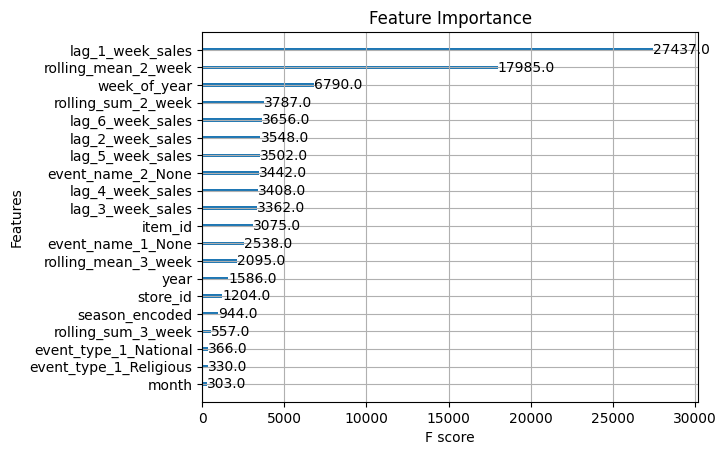

In [35]:
xgb.plot_importance(final_model, importance_type='weight', max_num_features=20)
plt.title("Feature Importance")
plt.show()

#### 6.3. Prediction

In [ ]:
final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)

test_data['weekly_sales'] = final_model.predict(X_test)

if logarithm:
    test_data['weekly_sales'] = np.expm1(test_data['weekly_sales'])
    
test_data['weekly_sales'] = test_data['weekly_sales'].round()

### 7. Saving predictions

In [34]:
submission_format = pd.read_csv("/kaggle/input/test-task-for-ds-time-series-forecasting-2025-01/ts_submission.csv")

predictions_path = "/kaggle/working/predictions.csv"

submission = submission_format.copy()
submission['y'] = submission['index'].map(test_data.set_index('index')['weekly_sales'])
submission['y'] = submission['y'].fillna(1)

submission.to_csv(predictions_path, index=False)

In [ ]:
print("Notebook finished!")